## Predict cloud coverage

- Predicting cloud cover in a short time span of 120 minutes is very challenging.
- On this time scale, changes in local cloud cover are driven by a combination of dynamical and physical parameters such as wind speed, wind direction sea-level pressure, humidity, and temperature over the asset of our interest.
- Short interval cloud cover prediction requires accurate estimates of cloud motion and presence using weather data and sky camera images or physics-based&nbsp;weather models or a combination of both. 

### Goal:
#### Predict the percentage of total cloud coverage for the next upcoming intervals using the available weather and sky camera data.  

We are expected to predict the total cloud coverage as a percentage of the open sky for a fixed field of view at 4 horizon intervals of 30, 60, 90, and 120 minutes from a 6-hour window of historical data.  

While validating and testing the predictions made by model, we are not supposed to consider **DATE (MM/DD)** and **MST** in a day as input features.  
So the task at hand is to make a model which will be generic throughout the year for any day and any time.  

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
PATH_FOLDER_DATASET = "dataset"
PATH_FOLDER_TRAINING = os.path.join(PATH_FOLDER_DATASET,"train")

Let's import training dataset

In [3]:
weather_df = pd.read_csv(os.path.join(PATH_FOLDER_TRAINING, "train.csv"))
weather_df.head(5)

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,1/1,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0


In [4]:
weather_df.shape

(527040, 17)

The local weather data was recorded for 366 days for 1 minute frequency, this makes $366\times24\times60 = 527040$ rows, which is correct  

Now the raw sky camera images were recorded at 10 minute frquence for the same duration. Let's see total number of images

In [5]:
import filetype 

images_count = {}
junks_count = {}

for file in os.scandir(PATH_FOLDER_TRAINING):
    if file.is_dir():
        images_count[file.name] = 0
        junks_count[file.name] = 0
        
        for image in os.scandir(file.path):
            if filetype.is_image(image.path):
                images_count[file.name] += 1
            else:
                junks_count[file.name] += 1

junks_count = np.array(list(junks_count.items()), dtype=object)
images_count = np.array(list(images_count.items()), dtype=object)

In [6]:
print("Junk files in image folder: ", junks_count[np.where(junks_count[:, 1] > 0)])
print("Folders with no images recorded: ", images_count[np.where(images_count[:, 1] == 0)][:,0])

Junk files in image folder:  []
Folders with no images recorded:  ['0404' '0405']


Seems like images were not recorded on 4th & 5th April. Maybe we won't be able to consider weather data for these 2 dates during training. Althugh nothing junk found!  


Since images were captured with 10 mins frquency in a day, let's take a peek at image counts per day.

In [7]:
print("Unique image counts per folder (day):")
np.unique(images_count[:,1])

Unique image counts per folder (day):


array([0, 5, 7, 11, 12, 13, 14, 28, 31, 50, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
      dtype=object)

Very irregular!  

### Analyzing Weather Data

In [8]:
weather_df.head(3)

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.0,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.0,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.0,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0


In [9]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   DATE (MM/DD)                           527040 non-null  object 
 1   MST                                    527040 non-null  object 
 2   Global CMP22 (vent/cor) [W/m^2]        527040 non-null  float64
 3   Direct sNIP [W/m^2]                    527040 non-null  float64
 4   Azimuth Angle [degrees]                527040 non-null  float64
 5   Tower Dry Bulb Temp [deg C]            527040 non-null  float64
 6   Tower Wet Bulb Temp [deg C]            527040 non-null  float64
 7   Tower Dew Point Temp [deg C]           527040 non-null  float64
 8   Tower RH [%]                           527040 non-null  float64
 9   Total Cloud Cover [%]                  527040 non-null  int64  
 10  Peak Wind Speed @ 6ft [m/s]            527040 non-null  

Renaming the features to make them simpler to understand.  
I have researched some information about significance of each feature and devices that they were measured from and documented [here](https://github.com/mrutyunjay17/solar-power-prediction/blob/main/Documentation.md).

In [10]:
ORIGINAL_FEATURE_NAMES = weather_df.columns

CUSTOM_FEATURE_NAMES = {
    'DATE (MM/DD)':'date',
    'MST':'time',  
    'Global CMP22 (vent/cor) [W/m^2]':'pyranometer',
    'Direct sNIP [W/m^2]':'pyroheliometer',  
    'Azimuth Angle [degrees]':'azimuth_angle',
    'Tower Dry Bulb Temp [deg C]':'tower_dry_bulb_temp', 
    'Tower Wet Bulb Temp [deg C]':'tower_wet_bulb_temp',
    'Tower Dew Point Temp [deg C]':'tower_dew_point', 
    'Tower RH [%]':'tower_rh', 
    'Total Cloud Cover [%]':'total_cloud_coverage',
    'Peak Wind Speed @ 6ft [m/s]':'peak_wind_speed', 
    'Avg Wind Direction @ 6ft [deg from N]':'avg_wind_direction',
    'Station Pressure [mBar]':'station_pressure', 
    'Precipitation (Accumulated) [mm]':'precipitation',
    'Snow Depth [cm]':'snow_depth', 
    'Moisture':'moisture', 
    'Albedo (CMP11)':'albedometer'
}

In [11]:
weather_df.rename(columns=CUSTOM_FEATURE_NAMES, inplace=True)
weather_df.head(4)

,date,time,pyranometer,pyroheliometer,azimuth_angle,tower_dry_bulb_temp,tower_wet_bulb_temp,tower_dew_point,tower_rh,total_cloud_coverage,peak_wind_speed,avg_wind_direction,station_pressure,precipitation,snow_depth,moisture,albedometer
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0


Seems like given dataset does not have null values.

In [12]:
weather_df.isnull().sum()

date                    0
time                    0
pyranometer             0
pyroheliometer          0
azimuth_angle           0
tower_dry_bulb_temp     0
tower_wet_bulb_temp     0
tower_dew_point         0
tower_rh                0
total_cloud_coverage    0
peak_wind_speed         0
avg_wind_direction      0
station_pressure        0
precipitation           0
snow_depth              0
moisture                0
albedometer             0
dtype: int64

But since most of the features are actually readings from different types of sensors, we need to stay aware of presence of for false reading/device problems/irrelavant reading which may interfare our prediction performances irregularly.  

### Assumption
Since we are not provided the year when this data was recorded, and also final model will also not be aware of actual time, since dataset does not provide year, we'll merge date and time columns and append year as some leap year (366 days) to make a single datetime column

In [25]:
# Merge datetime and get dependant variable as last column
def add_datetime_column(weather_df):
    weather_df['datetime'] = pd.to_datetime('2020/'+weather_df['date']+ ' ' + weather_df['time'])
    cloud_coverage = weather_df['total_cloud_coverage']
    weather_df = weather_df.drop(['date', 'time', 'total_cloud_coverage'], axis=1)
    weather_df['total_cloud_coverage'] = cloud_coverage
    return weather_df

In [26]:
weather_df = add_datetime_column(weather_df)
weather_df.head(3)

,pyranometer,pyroheliometer,azimuth_angle,tower_dry_bulb_temp,tower_wet_bulb_temp,tower_dew_point,tower_rh,peak_wind_speed,avg_wind_direction,station_pressure,precipitation,snow_depth,moisture,albedometer,datetime,total_cloud_coverage
0,-0.962276,0.0,356.85640,7.216,0.988,-7.312,32.33,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01 00:00:00,-1
1,-0.937921,0.0,357.65505,7.251,1.040,-7.260,32.40,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01 00:01:00,-1
2,-0.944395,0.0,358.45438,7.256,1.093,-7.207,32.54,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01 00:02:00,-1


<AxesSubplot:>

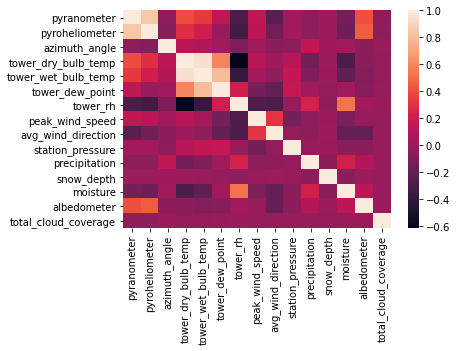

In [27]:
import seaborn as sns

sns.heatmap(weather_df.corr())